# Train a Model to Predict the Scorecard Recall of a YoloV5 Model 

In [4]:
from fastai.vision.all import *
import timm

# Data Locations and Counts

### Create DF with the y (Recall)

In [5]:
%cd ~/git/ZE_Scorecard_Predictor/
df_recall = pd.read_csv('ignore/data/csvs_dir/fp16_recalls_sc20240312.csv')
df_recall.head(2)

/home/zedram/git/ZE_Scorecard_Predictor


,model_id,recall
0,395,0.83
1,396,0.83


#### Toy dataset 42k

In [8]:
path = Path('.')
imgs_path = Path(path/"ignore/data/train_model_classifier_best_results_0329_datasets/trn_val_toy_600_D_1640/")

#### Huge dataset of 85k

In [9]:
# imgs_path = Path(path/"ignore/data/generalize_multi_model_toy_600/all_exps_from_printing/small_sz_copies/")

#### Lets check the image paths and data

In [10]:
imgs_path

Path('ignore/data/train_model_classifier_best_results_0329_datasets/trn_val_toy_600_D_1640')

In [68]:
get_image_files(imgs_path)

(#42240) [Path('ignore/data/train_model_classifier_best_results_0329_datasets/trn_val_toy_600_D_1640/bad/Z_272_080722_inside_PM25_CM85_01352_stage23_C3_features.png'),Path('ignore/data/train_model_classifier_best_results_0329_datasets/trn_val_toy_600_D_1640/bad/Z_272_080722_inside_PM25_CM85_22193_stage22_Concat_features.png'),Path('ignore/data/train_model_classifier_best_results_0329_datasets/trn_val_toy_600_D_1640/bad/Z_373_080722_inside_PM25_CM85_24180_stage16_Concat_features.png'),Path('ignore/data/train_model_classifier_best_results_0329_datasets/trn_val_toy_600_D_1640/bad/Z_420_080722_inside_PM25_CM85_02748_stage23_C3_features.png'),Path('ignore/data/train_model_classifier_best_results_0329_datasets/trn_val_toy_600_D_1640/bad/Z_272_080722_inside_PM25_CM85_07872_stage18_Conv_features.png'),Path('ignore/data/train_model_classifier_best_results_0329_datasets/trn_val_toy_600_D_1640/bad/Z_375_080722_inside_PM25_CM85_04215_stage20_C3_features.png'),Path('ignore/data/train_model_classifi

In [16]:
img_files = get_image_files(imgs_path)

### Now we look a our models we'll be using

In [17]:
models_in_test = list(set([int(o.name[2:5]) for o in img_files])); models_in_test

[291, 420, 293, 272, 373, 375, 382, 383]

In [18]:
pd.set_option('display.precision', 17)

df_recall.loc[df_recall.model_id.isin(models_in_test)]

,model_id,recall
21,383,0.72999999999999998
26,382,0.72999999999999998
46,293,0.70999999999999996
48,291,0.70999999999999996
49,420,0.70999999999999996
55,375,0.69999999999999996
76,373,0.68000000000000005
85,272,0.68000000000000005


### Make a target function from the filename - Create get_y function

In [21]:
def get_targ(x):
    recall = df_recall.loc[df_recall.model_id == int(x.name[2:5]),'recall'].values[0]
    return recall    

### Create splitter function

In [33]:
def splitter_one_model(o):
    return o.name[2:5] == '420'

In [38]:
len([splitter_one_model(o) for o in img_files[:100000] if o.name[2:5] == '420'])

6600

### create datablock

In [97]:
# fns = get_image_files(path)
# mod_feat = DataBlock(blocks = (ImageBlock, RegressionBlock), get_items=get_image_files,
#     splitter=RandomSplitter(valid_pct=0.2, seed=42), get_y=parent_label, item_tfms=Resize(224))

In [39]:
path = imgs_path

In [40]:
# fns = get_image_files(imgs)
mod_feat = DataBlock(blocks = (ImageBlock, RegressionBlock), get_items=get_image_files,
    splitter=FuncSplitter(lambda o: o.name[2:5] == '420'), get_y=get_targ, item_tfms=Resize(224))

### create data loaders

In [41]:
dls = mod_feat.dataloaders(imgs_path, batch_size=64,)

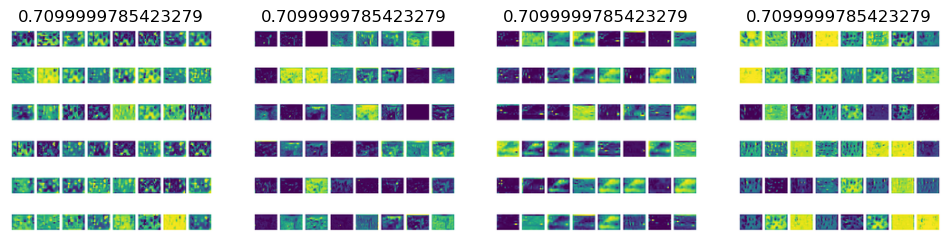

In [42]:
dls.valid.show_batch(max_n=4, nrows=1)

### Swin might be useful for lager models

In [44]:
L(timm.list_models('swin*'))

(#40) ['swin_base_patch4_window7_224','swin_base_patch4_window7_224_in22k','swin_base_patch4_window12_384','swin_base_patch4_window12_384_in22k','swin_large_patch4_window7_224','swin_large_patch4_window7_224_in22k','swin_large_patch4_window12_384','swin_large_patch4_window12_384_in22k','swin_s3_base_224','swin_s3_small_224'...]

In [ ]:
# learn = vision_learner(dls,'convnextv2_tiny', metrics=error_rate).to_fp16()
# learn = vision_learner(dls,'swin_s3_tiny_224', metrics=error_rate).to_fp16()

In [45]:
# learn = vision_learner(dls,'convnextv2_tiny', metrics=error_rate).to_fp16()
learn = vision_learner(dls,'swin_s3_tiny_224',y_range=(.4,.9)).to_fp16()

/home/zedram/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SuggestedLRs(valley=0.001737800776027143)

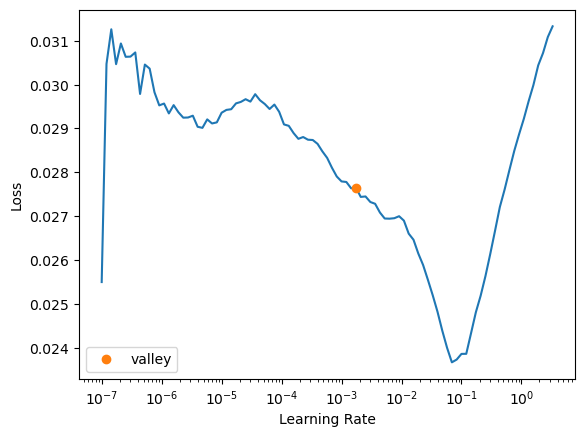

In [46]:
learn.lr_find()

In [50]:
# lr = 1e-2
learn.fine_tune(5)

epoch,train_loss,valid_loss,time
0,0.000740,0.000765,01:34


epoch,train_loss,valid_loss,time
0,0.000339,0.002095,01:56
1,0.000251,0.002144,01:56
2,0.000162,0.001541,01:57
3,0.000123,0.001561,01:57
4,0.000113,0.001449,01:57


### Now we try the big swin

### lets try using Random Splitter

In [77]:
mod_feat = DataBlock(blocks = (ImageBlock, RegressionBlock), get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), get_y=get_targ, item_tfms=Resize(224))

In [79]:
dls = mod_feat.dataloaders(imgs_path, batch_size=64,)

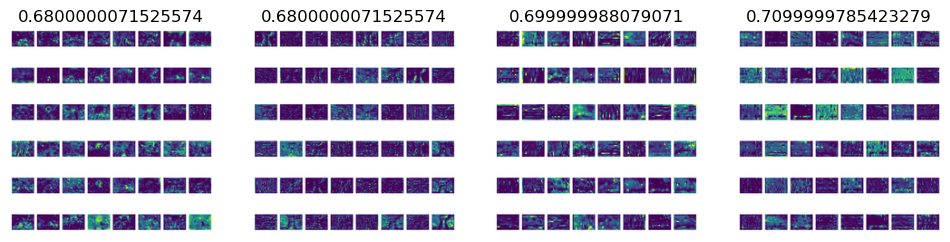

In [82]:
dls.valid.show_batch(max_n=4, nrows=1)

## Top choice model! RMSE .009

In [83]:
# learn = vision_learner(dls,'convnextv2_tiny', metrics=error_rate).to_fp16()
learn = vision_learner(dls,'swin_s3_tiny_224',y_range=(.4,.9)).to_fp16()

In [85]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,time
0,0.001718,0.000481,00:44


epoch,train_loss,valid_loss,time
0,0.000507,0.000197,00:53
1,0.000297,0.000108,00:53
2,0.000224,0.000087,00:53


In [88]:
'mrse: ', math.sqrt(.000087)

('mrse: ', 0.009327379053088815)

## Convnext with Randomized split  .005

In [90]:
learn.show_results(ds_idx=1, nrows=3)

In [86]:
# learn = vision_learner(dls,'convnextv2_tiny', metrics=error_rate).to_fp16()
learn = vision_learner(dls,'convnext_nano',y_range=(.4,.9)).to_fp16()

In [87]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,time
0,0.001699,0.000310,00:20


epoch,train_loss,valid_loss,time
0,0.000404,0.000295,00:29
1,0.000203,0.000047,00:29
2,0.000138,0.000029,00:29


In [91]:
'mrse: ', math.sqrt(.000029)

('mrse: ', 0.005385164807134504)

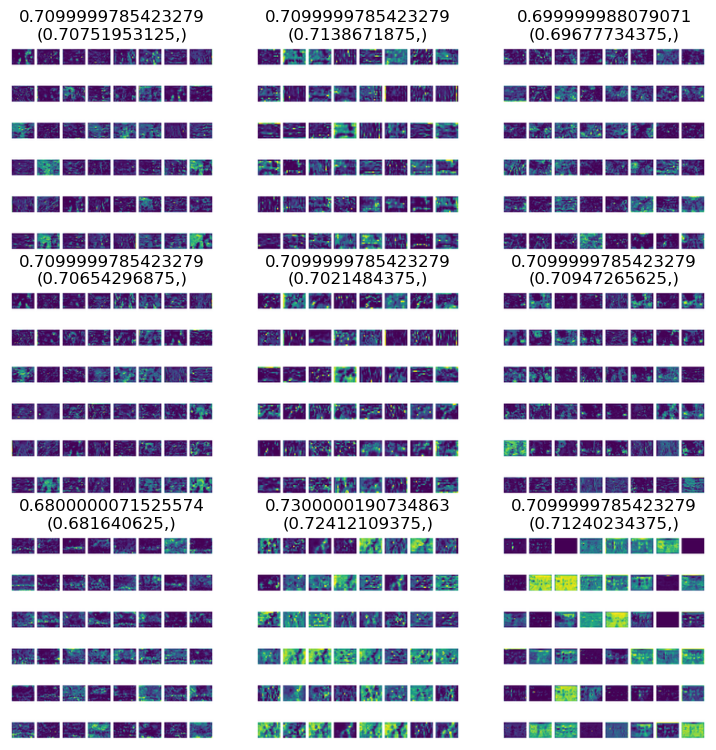

In [92]:
learn.show_results(ds_idx=1, nrows=3)

### Now lets try other models as the val

In [48]:
#### half the toy set

In [41]:
lr = 1e-2
learn.fine_tune(4,lr)

epoch,train_loss,valid_loss,time
0,0.001325,0.000175,00:13


epoch,train_loss,valid_loss,time
0,0.000281,0.001887,00:14
1,0.000303,0.000527,00:14
2,0.000158,0.001269,00:14
3,0.000091,0.001104,00:15


In [63]:
# lr = 1e-2
learn.fine_tune(5)

epoch,train_loss,valid_loss,time
0,0.001117,0.001753,01:00


epoch,train_loss,valid_loss,time
0,0.000428,0.000597,01:14
1,0.000276,0.001571,01:13
2,0.000184,0.000749,01:13
3,0.000137,0.001522,01:13
4,0.000113,0.001340,01:14


In [43]:
# lr = 1e-2
learn.fine_tune(5)

epoch,train_loss,valid_loss,time
0,0.014583,0.003190,00:12


epoch,train_loss,valid_loss,time
0,0.006026,0.000357,00:14
1,0.002979,0.001311,00:14
2,0.001362,0.000878,00:14
3,0.000947,0.001163,00:14
4,0.000838,0.000927,00:14


# Lets try with saturation augmentation

In [266]:
dls.loss_func

FlattenedLoss of MSELoss()

In [45]:
math.sqrt(.00092)

0.030331501776206204

In [46]:
df_recall

,model_id,recall
0,395,0.83
1,396,0.83
2,397,0.83
3,393,0.82
4,425,0.80
...,...,...
172,20,0.00
173,124,0.00
174,69,0.00
175,37,0.00


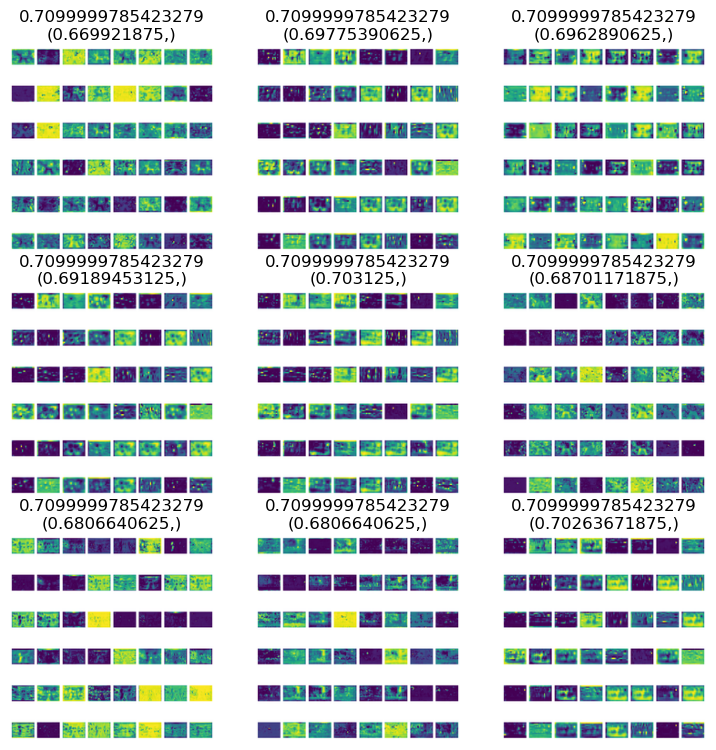

In [47]:
learn.show_results(ds_idx=1, nrows=3)

Above shows highest loss images on the left with lowest loss images on the right.  Investigating which images have the highest loss might help us find clusters of images that could be more important for training

## Run on test set

In [99]:
test_files = get_image_files('test_set_toy_600_D_1640/')

In [100]:
# Test on one image
# img = PILImage.create(test_files[0]); img
# learn.predict(img)

In [101]:
tst_dl = dls.test_dl(test_files)
# tst_dl.show_batch(max_n=3)

In [103]:
preds = learn.get_preds(dl=tst_dl, with_decoded=True, with_targs=True, )
x, y, z = preds

# Print Prediction results
print('test size: ', z.shape[0])
# Grab the models used in this set
unique_items = set([o.name[:5] for o in tst_dl.items])
models_used = list(unique_items)
print('models in set: ', models_used)

predictions = pd.Series(z.numpy(), name = "predictions")
predictions = predictions.tolist()

print('Prediction count: ', z.shape)

# Create column 'probability_one'. 
pred_prob = pd.DataFrame(x.numpy().tolist(), columns=['prob_zero','probability_one'])

pred_prob = pred_prob.drop(columns = 'prob_zero')

# Create 'predictions' column 0 is model A(dls.vocab[0]), 1 is model B(dls.vocab[0])
predictions = z.numpy().tolist()

# Create 'image' name column
tst_dl_files = [path.name for path in tst_dl.items]

df = pd.DataFrame()
df = pd.DataFrame({'image': tst_dl_files, 'preds': predictions, 'class' : [o.parent.name for o in tst_dl.items]})

print('classes are' , dls.vocab)

df['g_truth'] = df['class'].apply(lambda x: 1 if dls.vocab[1] in x else 0)

# Merge 'probability_one' column to the rest of the df
df = df.merge(pred_prob, left_index=True, right_index=True)

# Calculate RMSE
rmse = np.sqrt(((df.g_truth - df.probability_one)**2).mean()); 
print('rmse: ',rmse); print()
print("Accuracy: ", df.loc[df.g_truth==df.preds].shape[0]/df.shape[0])

df

test size:  10560
models in set:  ['Z_420', 'Z_291', 'Z_375', 'Z_382', 'Z_383', 'Z_293', 'Z_272', 'Z_373']
Prediction count:  torch.Size([10560])
classes are ['bad', 'good']
rmse:  0.0006378562069713729

Accuracy:  1.0


,image,preds,class,g_truth,probability_one
0,Z_373_080722_inside_PM25_CM85_18651_stage16_Concat_features.png,0,bad,0,2.151007e-11
1,Z_373_080722_inside_PM25_CM85_25379_stage19_Concat_features.png,0,bad,0,8.327813e-10
2,Z_373_080722_inside_PM25_CM85_04235_stage22_Concat_features.png,0,bad,0,1.419590e-08
3,Z_420_080722_inside_PM25_CM85_15589_stage19_Concat_features.png,0,bad,0,4.518244e-11
4,Z_420_080722_inside_PM25_CM85_10507_stage20_C3_features.png,0,bad,0,3.451783e-09
...,...,...,...,...,...
10555,Z_382_080722_inside_PM25_CM85_24407_stage15_Upsample_features.png,1,good,1,1.000000e+00
10556,Z_291_080722_inside_PM25_CM85_15724_stage21_Conv_features.png,1,good,1,1.000000e+00
10557,Z_383_080722_inside_PM25_CM85_24407_stage22_Concat_features.png,1,good,1,9.999996e-01
10558,Z_293_080722_inside_PM25_CM85_22061_stage16_Concat_features.png,1,good,1,1.000000e+00


# Test on Unseen Models Test Set

In [76]:
test_files = get_image_files('virgin_test_set_toy_600_D_1640/')

tst_dl = dls.test_dl(test_files)

preds = learn.get_preds(dl=tst_dl, with_decoded=True, with_targs=True, )
x, y, z = preds

# Accuracy of .994 !!

In [77]:
# Print Prediction results
print('test size: ', z.shape[0])
# Grab the models used in this set
unique_items = set([o.name[:5] for o in tst_dl.items])
models_used = list(unique_items)
print('models in set: ', models_used)

predictions = pd.Series(z.numpy(), name = "predictions")
predictions = predictions.tolist()

print('Prediction count: ', z.shape[0],' feature maps')

# Create column 'probability_one'. 
pred_prob = pd.DataFrame(x.numpy().tolist(), columns=['prob_zero','probability_one'])
pred_prob = pred_prob.drop(columns = 'prob_zero')
predictions = z.numpy().tolist()

# Create 'image' name column
tst_dl_files = [path.name for path in tst_dl.items]

df = pd.DataFrame()
df = pd.DataFrame({'image': tst_dl_files, 'preds': predictions, 'class' : [o.parent.name for o in tst_dl.items]})
print('classes are' , dls.vocab)
# Create Ground Truth colum containg 1 or 0 based on the dls.vocab given ie ['bad','good'] or ['good','bad']
df['g_truth'] = df['class'].apply(lambda x: 1 if dls.vocab[1] in x else 0)

# Merge 'probability_one' column to the rest of the df
df = df.merge(pred_prob, left_index=True, right_index=True)

# Calculate RMSE
rmse = np.sqrt(((df.g_truth - df.probability_one)**2).mean()); 
print('rmse: ',rmse); print()
print("Accuracy: ", df.loc[df.g_truth==df.preds].shape[0]/df.shape[0])
df

test size:  2640
models in set:  ['Z_367', 'Z_290']
Prediction count:  2640  feature maps
classes are ['bad', 'good']
rmse:  0.06669921276931454

Accuracy:  0.9946969696969697


,image,preds,class,g_truth,probability_one
0,Z_367_080722_inside_PM25_CM85_10223_stage18_Conv_features.png,0,bad,0,3.954844e-01
1,Z_367_080722_inside_PM25_CM85_07698_stage22_Concat_features.png,0,bad,0,3.327516e-06
2,Z_367_080722_inside_PM25_CM85_09945_stage22_Concat_features.png,0,bad,0,1.669671e-07
3,Z_367_080722_inside_PM25_CM85_11468_stage21_Conv_features.png,0,bad,0,3.425942e-07
4,Z_367_080722_inside_PM25_CM85_18989_stage18_Conv_features.png,0,bad,0,5.044728e-05
...,...,...,...,...,...
2635,Z_290_080722_inside_PM25_CM85_01332_stage17_C3_features.png,1,good,1,9.999998e-01
2636,Z_290_080722_inside_PM25_CM85_19659_stage15_Upsample_features.png,1,good,1,9.999986e-01
2637,Z_290_080722_inside_PM25_CM85_24381_stage18_Conv_features.png,1,good,1,1.000000e+00
2638,Z_290_080722_inside_PM25_CM85_11347_stage15_Upsample_features.png,1,good,1,1.000000e+00


In [89]:
test_files = get_image_files('virgin_test_set_toy_600_D_1640/')

tst_dl = dls.test_dl(test_files)

preds = learn.get_preds(dl=tst_dl, with_decoded=True, with_targs=True, )
x, y, z = preds

In [90]:
# Print Prediction results
print('test size: ', z.shape[0])
# Grab the models used in this set
unique_items = set([o.name[:5] for o in tst_dl.items])
models_used = list(unique_items)
print('models in set: ', models_used)

predictions = pd.Series(z.numpy(), name = "predictions")
predictions = predictions.tolist()

print('Prediction count: ', z.shape[0],' feature maps')

# Create column 'probability_one'. 
pred_prob = pd.DataFrame(x.numpy().tolist(), columns=['prob_zero','probability_one'])

pred_prob = pred_prob.drop(columns = 'prob_zero')

# Create 'predictions' column 0 is model A(dls.vocab[0]), 1 is model B(dls.vocab[0])
predictions = z.numpy().tolist()

# Create 'image' name column
tst_dl_files = [path.name for path in tst_dl.items]

df = pd.DataFrame()
df = pd.DataFrame({'image': tst_dl_files, 'preds': predictions, 'class' : [o.parent.name for o in tst_dl.items]})

print('classes are' , dls.vocab)

df['g_truth'] = df['class'].apply(lambda x: 1 if dls.vocab[1] in x else 0)

# Merge 'probability_one' column to the rest of the df
df = df.merge(pred_prob, left_index=True, right_index=True)

# Calculate RMSE
rmse = np.sqrt(((df.g_truth - df.probability_one)**2).mean()); 
print('rmse: ',rmse); print()
print("Accuracy: ", df.loc[df.g_truth==df.preds].shape[0]/df.shape[0])

df

test size:  2640
models in set:  ['Z_367', 'Z_290']
Prediction count:  2640  feature maps
classes are ['bad', 'good']
rmse:  0.05383384276913795

Accuracy:  0.9954545454545455


,image,preds,class,g_truth,probability_one
0,Z_367_080722_inside_PM25_CM85_10223_stage18_Conv_features.png,0,bad,0,3.027388e-01
1,Z_367_080722_inside_PM25_CM85_07698_stage22_Concat_features.png,0,bad,0,5.073847e-06
2,Z_367_080722_inside_PM25_CM85_09945_stage22_Concat_features.png,0,bad,0,2.291102e-07
3,Z_367_080722_inside_PM25_CM85_11468_stage21_Conv_features.png,0,bad,0,8.413298e-07
4,Z_367_080722_inside_PM25_CM85_18989_stage18_Conv_features.png,0,bad,0,4.416214e-07
...,...,...,...,...,...
2635,Z_290_080722_inside_PM25_CM85_01332_stage17_C3_features.png,1,good,1,1.000000e+00
2636,Z_290_080722_inside_PM25_CM85_19659_stage15_Upsample_features.png,1,good,1,1.000000e+00
2637,Z_290_080722_inside_PM25_CM85_24381_stage18_Conv_features.png,1,good,1,1.000000e+00
2638,Z_290_080722_inside_PM25_CM85_11347_stage15_Upsample_features.png,1,good,1,1.000000e+00
